In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

class Layer:
    def __init__(self, input_size=None, output_size=None, weights=None, bias=None):
        self.input = None
        self.output = None
        if (input_size is None or output_size is None) and (weights is None or bias is None):
            raise Exception('input and output sizes or weights with bias are required')
        if weights is None:
            self.weights = np.random.rand(input_size, output_size) # uniform
        else:
            self.weights = weights
            self.input_size = len(self.weights)
            self.output_size = len(self.weights[0])
        if bias is None:
            self.bias = np.random.rand(1, output_size)
        else:
            self.bias = bias

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        d_weights = -learning_rate * weights_error
        d_bias = -learning_rate * output_error
        return input_error, d_weights, d_bias
    
    def update_weights(self, d_weights, d_bias):
        self.weights += d_weights
        self.bias += d_bias
        
    
class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.input = None
        self.output = None
        self.activation = activation
        self.activation_prime = activation_prime

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [2]:
def update_list(l, new_el):
    new_l = [None] * len(l)
    for i in range(len(l)-1, 0, -1):
        new_l[i] = l[i-1]
    new_l[0] = new_el
    return new_l

def check_early_stopping(l):
    for i in range(len(l)-1):
        if l[i] < l[i+1]:
            return False
    return True

In [3]:
from copy import deepcopy

class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None
        self.errors = []
        self.val_errors = []

    def add(self, layer):
        self.layers.append(layer)

    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    def predict(self, input_data):
        samples = len(input_data)
        result = []

        for i in range(samples):
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    def fit(self, x_train, y_train, epochs, learning_rate, batch_size, x_val=None,
            y_val=None, early_stopping=None, regularisation=None):
        
        
        if regularisation is not None:
            if type(regularisation) != list:
                raise Exception("Regularisation should be list, example: ['L1', 0.1], where first\
                                element is type of regularisation, second is parameter (lambda)")

        samples = len(x_train)
        
        if early_stopping != None:
            if x_val is None or y_val is None:
                raise Exception('Missing validations sets')
            last_errors = [i for i in range(early_stopping)]
        
        batch_proportion = batch_size/samples

        for i in range(epochs):
            err = 0
            
            for batch_number in range(int(1/batch_proportion)):
                
                layersDeltaWeight = []
                layersDeltaBias = []
                
                for j in range(int(batch_number * batch_size), int((batch_number+1)*batch_size)):
                    
                    #forward propagation
                    
                    output = x_train[j]
                    
                    for layer in self.layers:
                        output = layer.forward_propagation(output)

                    err += self.loss(y_train[j], output)
                    
                    if regularisation is not None:
                        
                        full_layers_weights = []
                        for layer in self.layers:
                            if isinstance(layer, Layer):
                                full_layers_weights.append(layer.weights)
                        
                        err_reg = 0
                                
                        if regularisation[0] == 'L1':
                  
                            for weights in full_layers_weights:
                                err_reg += np.sum(np.abs(weights))
                                
                        elif regularisation[0] == 'L2':
                            
                            for weights in full_layers_weights:
                                err_reg += np.sum(np.power(weights, 2))
                            
                        else:
                            raise Exception('Incorrect regularisation type')
                        
                        err_reg *= regularisation[1] / (2*samples)
                        err += err_reg
                    
                    #backward propagation
                    
                    
                    error = self.loss_prime(y_train[j], output)
                    
                    
                    tmplayerDeltaWeights = []
                    tmplayerDeltaBias = []
                    for layer in reversed(self.layers):
                        
                        if isinstance(layer, ActivationLayer):
                            
                            error = layer.backward_propagation(error, learning_rate)
                            
                        else:
                            error, deltaWeights, deltaBias = layer.backward_propagation(error, learning_rate)
                            tmplayerDeltaWeights.append(deltaWeights)
                            tmplayerDeltaBias.append(deltaBias)
                        
                    layersDeltaWeight.append(tmplayerDeltaWeights)
                    layersDeltaBias.append(tmplayerDeltaBias)
                    
                for layerdWeight, layerdBias in zip(layersDeltaWeight, layersDeltaBias):
                    
                    only_full_layers = []
                    
                    for layer in reversed(self.layers):
                        
                        if isinstance(layer, Layer):
                            
                            only_full_layers.append(layer)
                            
                    for dWeight, dBias, layer in zip(layerdWeight, layerdBias, only_full_layers):
                        
                        error_reg = 0
                        
                        if regularisation is not None:             
                            if regularisation[0] == 'L2':
                                
                                error_reg += layer.weights * regularisation[1] / samples
                                
                        layer.update_weights(dWeight + error_reg, dBias)

            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))
            
            self.errors.append(err)
            
            if early_stopping != None:
                y_predicted_val = self.predict(x_val)
                new_err = self.loss(y_val, y_predicted_val)

                last_errors = update_list(last_errors, new_err)
                self.val_errors.append(new_err)

                if check_early_stopping(last_errors):
                    print(f'Last errors on validation set: {last_errors}')
                    print('early stopped')
                    break
                    
            if early_stopping is None and x_val is not None:
                
                y_predicted_val = self.predict(x_val)
                new_err = self.loss(y_val, y_predicted_val)
                self.val_errors.append(new_err)
                
            
            
            
    def fit_momentum(self, x_train, y_train, epochs, learning_rate, batch_size, lambd):

        samples = len(x_train)
        
        momentum_w = []
        momentum_b = []
        
        for layer in self.layers:
            
            if isinstance(layer, ActivationLayer):
                continue  
                
            momentum_w.append(deepcopy(layer.weights))
            momentum_b.append(deepcopy(layer.bias))
        
        momentum_w = np.array(momentum_w, dtype=object)
        
        for i in range(len(momentum_w)):
            momentum_w[i][:] = 0
            momentum_b[i][:] = 0

        batch_proportion = batch_size/samples

        for i in range(epochs):
            err = 0
            
            for batch_number in range(int(1/batch_proportion)):
                
                layersDeltaWeight = []
                layersDeltaBias = []
                
                for j in range(int(batch_number * batch_size), int((batch_number+1)*batch_size)):
                    
                    #forward propagation
                    
                    output = x_train[j]
                    
                    for layer in self.layers:
                        output = layer.forward_propagation(output)

                    err += self.loss(y_train[j], output)
                    
                    #backward propagation
                    
                    error = self.loss_prime(y_train[j], output)
                    
                    tmplayerDeltaWeights = []
                    tmplayerDeltaBias = []
                    for layer in reversed(self.layers):
                        
                        if isinstance(layer, ActivationLayer):
                            
                            error = layer.backward_propagation(error, learning_rate)
                            
                        else:
                            
                            error, deltaWeights, deltaBias = layer.backward_propagation(error, learning_rate)
                            tmplayerDeltaWeights.append(deltaWeights)
                            tmplayerDeltaBias.append(deltaBias)
                        
                    layersDeltaWeight.append(tmplayerDeltaWeights)
                    layersDeltaBias.append(tmplayerDeltaBias)
                    
                for layerdWeight, layerdBias in zip(layersDeltaWeight, layersDeltaBias):
                    
                    only_full_layers = []
                    
                    for layer in reversed(self.layers):
                        
                        if isinstance(layer, Layer):
                            
                            only_full_layers.append(layer)
                            
                    l = len(only_full_layers)
                            
                    for dWeight, dBias, layer in zip(layerdWeight, layerdBias, only_full_layers):
                        
                        l -= 1
                        momentum_w[l] = dWeight + learning_rate * momentum_w[l] * lambd
                        momentum_b[l] = dBias + learning_rate * momentum_b[l] * lambd
                        layer.update_weights(momentum_w[l], momentum_b[l])

            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))
            self.errors.append(err)
            
    def fit_RMSProp(self, x_train, y_train, epochs, learning_rate, batch_size, beta):
        
        samples = len(x_train)
        
        E_w = []
        E_b = []
        
        for layer in self.layers:
            
            if isinstance(layer, ActivationLayer):
                continue  
                
            E_w.append(deepcopy(layer.weights))
            E_b.append(deepcopy(layer.bias))
        
        E_w = np.array(E_w, dtype=object)
        
        for i in range(len(E_w)):
            E_w[i][:] = 0
            E_b[i][:] = 0
            
        batch_proportion = batch_size/samples

        for i in range(epochs):
            err = 0
            
            for batch_number in range(int(1/batch_proportion)):
                
                layersDeltaWeight = []
                layersDeltaBias = []
                
                for j in range(int(batch_number * batch_size), int((batch_number+1)*batch_size)):
                    
                    #forward propagation
                    
                    output = x_train[j]
                    
                    for layer in self.layers:
                        output = layer.forward_propagation(output)

                    err += self.loss(y_train[j], output)
                    
                    #backward propagation
                    
                    error = self.loss_prime(y_train[j], output)
                    
                    tmplayerDeltaWeights = []
                    tmplayerDeltaBias = []
                    for layer in reversed(self.layers):
                        
                        if isinstance(layer, ActivationLayer):
                            
                            error = layer.backward_propagation(error, learning_rate)
                            
                        else:
                            
                            error, deltaWeights, deltaBias = layer.backward_propagation(error, learning_rate)
                            tmplayerDeltaWeights.append(deltaWeights)
                            tmplayerDeltaBias.append(deltaBias)
                        
                    layersDeltaWeight.append(tmplayerDeltaWeights)
                    layersDeltaBias.append(tmplayerDeltaBias)
                    
                for layerdWeight, layerdBias in zip(layersDeltaWeight, layersDeltaBias):
                    
                    only_full_layers = []
                    
                    for layer in reversed(self.layers):
                        
                        if isinstance(layer, Layer):
                            
                            only_full_layers.append(layer)
                            
                    l = len(only_full_layers)
                            
                    for dWeight, dBias, layer in zip(layerdWeight, layerdBias, only_full_layers):
                        
                        l -= 1
                        E_w[l] = beta * E_w[l] + (1 - beta) * dWeight ** 2
                        E_b[l] = beta * E_b[l] + (1 - beta) * dBias ** 2
                        layer.update_weights(learning_rate * dWeight / np.sqrt(E_w[l]),
                                             learning_rate * dBias / np.sqrt(E_b[l]))

            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))
            self.errors.append(err)

In [4]:
def sigmoid(x):
    e = np.exp((-1)*x)
    return 1/(1+e)

def derivative_sigmoid(x):
    e = np.exp((-1)*x)
    return e / ((1+e)**2)

def linear(x):
    return x

def derivative_linear(x):
    return np.array([1 for i in x])

In [5]:
def softmax(x):
    expX = np.exp(x)
    return expX / np.sum(expX)

def derivative_softmax(x):
    s = softmax(x)[0]
    jacobian_m = np.diag(s)
    for i in range(len(jacobian_m)):
        for j in range(len(jacobian_m[0])):
            if i == j:
                jacobian_m[i][j] = 1 - s[i] ** 2
            else:
                jacobian_m[i][j] = -1 * s[i] * s[j]
    return np.diag(jacobian_m)

def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def derivative_tanh(x):
    return 1-tanh(x)**2

def relu(x):
    return np.maximum(x, 0)

def derivative_relu(x):
    return np.where(x > 0, 1, 0)

In [6]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

In [7]:
def cost_function(y_true, y_pred):  # cross-entropy
    
    y = [[0 for i in range(len(net.layers[len(net.layers)-2].output[0]))]]
    y[0][y_true[0][0]] = 1
    y = np.array(y)

    return -np.mean(y * np.log(y_pred + 1e-8))

def cost_function_prime(y_true, y_pred):
    
    y = [[0 for i in range(len(net.layers[len(net.layers)-2].output[0]))]]
    y[0][y_true[0][0]] = 1
    y = np.array(y)
    
    return y_pred - y

# NN2 PROPAGACJA WSTECZNA

In [ ]:
data = pd.read_csv('mio1/regression/square-simple-training.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

In [ ]:
np.random.seed(2203)

net = Network()
net.add(Layer(1, 200))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(200, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.0001, batch_size=50)

In [ ]:
err1 = net.errors

data = pd.read_csv('mio1/regression/square-simple-test.csv')
x_test = list(data.x)
y_test = list(data.y)
x_test = np.array([[[x]] for x in x_test])
y_test = np.array([[[y]] for y in y_test])
out = net.predict(x_test)
mse1 = mse(y_test, out)

print(mse1)

In [ ]:
data = pd.read_csv('mio1/regression/steps-small-training.csv')
x_test = list(data.x)
y_test = list(data.y)
x_test = np.array([[[x]] for x in x_test])
y_test = np.array([[[y]] for y in y_test])

np.random.seed(244)

net = Network()
net.add(Layer(1, 200))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(200, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_test, y_test, epochs=1000, learning_rate=0.005, batch_size=10)

In [ ]:
err2 = net.errors

data = pd.read_csv('mio1/regression/steps-small-test.csv')
x_test = list(data.x)
y_test = list(data.y)
x_test = np.array([[[x]] for x in x_test])
y_test = np.array([[[y]] for y in y_test])

out = net.predict(x_test)
mse2 = mse(y_test, out)
print(mse2)

In [ ]:
data = pd.read_csv('mio1/regression/multimodal-large-training.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

np.random.seed(2)

net = Network()
net.add(Layer(1, 32))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(32, 32))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(32, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=100, learning_rate=0.0005, batch_size=1)

In [ ]:
data = pd.read_csv('mio1/regression/multimodal-large-test.csv')
x_test = list(data.x)
y_test = list(data.y)
x_test = np.array([[[x]] for x in x_test])
y_test = np.array([[[y]] for y in y_test])

err3 = net.errors


out = net.predict(x_test)
mse3 = mse(y_test, out)
print(mse3)

In [ ]:
plt.plot(list(range(1, 1001)), err1, label='square-simple')
plt.plot(list(range(1, 1001)), err2, label='steps-small')
plt.plot(list(range(1, 101)), err3, label='multimodal-large')

plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.savefig('NN2.png')

In [ ]:
data = pd.read_csv('mio1/regression/square-simple-training.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

In [ ]:
np.random.seed(2203)

net = Network()
net.add(Layer(1, 200))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(200, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.0001, batch_size=1)

err1 = net.errors

data = pd.read_csv('mio1/regression/square-simple-test.csv')
x_test = list(data.x)
y_test = list(data.y)
x_test = np.array([[[x]] for x in x_test])
y_test = np.array([[[y]] for y in y_test])

out = net.predict(x_test)
mse1 = mse(y_test, out)
print(mse1)

In [ ]:
np.random.seed(2203)

net = Network()
net.add(Layer(1, 200))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(200, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.0001, batch_size=10)

err2 = net.errors

data = pd.read_csv('mio1/regression/square-simple-test.csv')
x_test = list(data.x)
y_test = list(data.y)
x_test = np.array([[[x]] for x in x_test])
y_test = np.array([[[y]] for y in y_test])

out = net.predict(x_test)
mse2 = mse(y_test, out)
print(mse2)

In [ ]:
np.random.seed(2203)

net = Network()
net.add(Layer(1, 200))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(200, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.00006, batch_size=100)

err3 = net.errors

data = pd.read_csv('mio1/regression/square-simple-test.csv')
x_test = list(data.x)
y_test = list(data.y)
x_test = np.array([[[x]] for x in x_test])
y_test = np.array([[[y]] for y in y_test])

out = net.predict(x_test)
mse3 = mse(y_test, out)
print(mse3)

In [ ]:
np.random.seed(2203)

net = Network()
net.add(Layer(1, 200))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(200, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.000095, batch_size=50)

err4 = net.errors

data = pd.read_csv('mio1/regression/square-simple-test.csv')
x_test = list(data.x)
y_test = list(data.y)
x_test = np.array([[[x]] for x in x_test])
y_test = np.array([[[y]] for y in y_test])

out = net.predict(x_test)
mse4 = mse(y_test, out)
print(mse4)

In [ ]:
plt.plot(list(range(1, 1001)), err1, label='batch_size=1')
plt.plot(list(range(1, 1001)), err2, label='batch_size=10')
plt.plot(list(range(1, 1001)), err4, label='batch_size=50')
plt.plot(list(range(1, 1001)), err3, label='batch_size=100')

plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.savefig('NN2_batch.png')

# NN3 MOMENTUM I RMSPROP

In [ ]:
data = pd.read_csv('mio1/regression/square-large-training.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

np.random.seed(2203)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit_momentum(x_train, y_train, epochs=100, learning_rate=0.0004, batch_size=100, lambd=0.5)

err1 = net.errors

In [ ]:
data = pd.read_csv('mio1/regression/square-large-training.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

np.random.seed(2203)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit_momentum(x_train, y_train, epochs=100, learning_rate=0.0002, batch_size=100, lambd=0.5)

err2 = net.errors

In [ ]:
data = pd.read_csv('mio1/regression/square-large-training.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

np.random.seed(2203)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit_momentum(x_train, y_train, epochs=100, learning_rate=0.0001, batch_size=100, lambd=0.5)

err3 = net.errors

In [ ]:
data = pd.read_csv('mio1/regression/square-large-training.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

np.random.seed(2203)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit_momentum(x_train, y_train, epochs=100, learning_rate=0.00008, batch_size=100, lambd=0.5)

err4 = net.errors

In [ ]:
data = pd.read_csv('mio1/regression/square-large-training.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

np.random.seed(2203)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit_momentum(x_train, y_train, epochs=100, learning_rate=0.00001, batch_size=100, lambd=0.5)

err5 = net.errors

In [ ]:
plt.plot(list(range(1, 101)), err2, label='learning_rate=0.0004')
plt.plot(list(range(1, 101)), err1, label='learning_rate=0.0002')
plt.plot(list(range(1, 101)), err3, label='learning_rate=0.0001')
plt.plot(list(range(1, 101)), err4, label='learning_rate=0.00008')
plt.plot(list(range(1, 101)), err5, label='learning_rate=0.00001')

plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.savefig('NN3_momentum.png')

In [ ]:
data = pd.read_csv('mio1/regression/square-large-test.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

np.random.seed(2203)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit_RMSProp(x_train, y_train, epochs=500, learning_rate=0.01, batch_size=100, beta=0.9)

err1 = net.errors

In [ ]:
data = pd.read_csv('mio1/regression/square-large-test.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

np.random.seed(2203)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit_RMSProp(x_train, y_train, epochs=500, learning_rate=0.005, batch_size=100, beta=0.9)

err2 = net.errors

In [ ]:
data = pd.read_csv('mio1/regression/square-large-test.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

np.random.seed(2203)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit_RMSProp(x_train, y_train, epochs=500, learning_rate=0.001, batch_size=100, beta=0.9)

err3 = net.errors

In [ ]:
data = pd.read_csv('mio1/regression/square-large-test.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

np.random.seed(2203)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit_RMSProp(x_train, y_train, epochs=500, learning_rate=0.0008, batch_size=100, beta=0.9)

err4 = net.errors

In [ ]:
data = pd.read_csv('mio1/regression/square-large-test.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

np.random.seed(2203)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit_RMSProp(x_train, y_train, epochs=500, learning_rate=0.0004, batch_size=100, beta=0.9)

err5 = net.errors

In [ ]:
plt.plot(list(range(1, 501)), err1, label='learning_rate=0.01')
plt.plot(list(range(1, 501)), err2, label='learning_rate=0.005')
plt.plot(list(range(1, 501)), err3, label='learning_rate=0.001')
plt.plot(list(range(1, 501)), err4, label='learning_rate=0.0008')
plt.plot(list(range(1, 501)), err5, label='learning_rate=0.0004')

plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.savefig('NN3_rmsprop.png')

In [ ]:
data = pd.read_csv('mio1/regression/square-large-test.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

np.random.seed(2203)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit_RMSProp(x_train, y_train, epochs=500, learning_rate=0.005, batch_size=100, beta=0.9)

err1 = net.errors

In [ ]:
data = pd.read_csv('mio1/regression/square-large-test.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

np.random.seed(2203)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit_RMSProp(x_train, y_train, epochs=500, learning_rate=0.005, batch_size=100, beta=0.8)

err2 = net.errors

In [ ]:
data = pd.read_csv('mio1/regression/square-large-test.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

np.random.seed(2203)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit_RMSProp(x_train, y_train, epochs=500, learning_rate=0.005, batch_size=100, beta=0.7)

err3 = net.errors

In [ ]:
data = pd.read_csv('mio1/regression/square-large-test.csv')
x_train = list(data.x)
y_train = list(data.y)
x_train = np.array([[[x]] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

np.random.seed(2203)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit_RMSProp(x_train, y_train, epochs=500, learning_rate=0.005, batch_size=100, beta=0.3)

err4 = net.errors

In [ ]:
plt.plot(list(range(1, 501)), err1, label='beta=0.9')
plt.plot(list(range(1, 501)), err2, label='beta=0.8')
plt.plot(list(range(1, 501)), err3, label='beta=0.7')
plt.plot(list(range(1, 501)), err4, label='beta=0.3')

plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.savefig('NN3_beta.png')

# NN4

In [ ]:
data = pd.read_csv('mio1/classification/easy-training.csv')
y_train = list(data.c.astype(int))
x_train = data[['x', 'y']].values.tolist()

In [ ]:
import seaborn

seaborn.relplot(data=data, x='x', y='y', hue='c', aspect=1.61)
plt.show()

In [ ]:
x_train = np.array([[x] for x in x_train])
y_train = np.array([[[y]] for y in y_train])

In [ ]:
np.random.seed(2203) # 2203
net = Network()
net.add(Layer(2, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 2))
net.add(ActivationLayer(softmax, derivative_softmax))

net.use(cost_function, cost_function_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.0001, batch_size=50)

In [ ]:
err = net.errors

In [ ]:
plt.plot(list(range(1, 1001)), err)

plt.ylabel('cross-entropy')
plt.xlabel('epoch')
plt.savefig('NN4_easy_learning.png')

In [ ]:
data = pd.read_csv('mio1/classification/easy-test.csv')
y_test = list(data.c.astype(int))
x_test = data[['x', 'y']].values.tolist()
x_test = np.array([[x] for x in x_test])
out = net.predict(x_test)

In [ ]:
out = [np.argmax(l) for l in out]

In [ ]:
d = {'x': data.x, 'y': data.y, 'c': out}
df = pd.DataFrame(data=d)

In [ ]:
fig, ax =plt.subplots(1,2)
fig.set_size_inches(14, 7)

seaborn.scatterplot(data=data, x='x', y='y', hue='c', ax=ax[0])
seaborn.scatterplot(data=df, x='x', y='y', hue='c', ax=ax[1])
fig.show()

# NN5

In [ ]:
data = pd.read_csv('mio1/regression/multimodal-large-training.csv')

y_train = list(data.y)
y_train = np.array([[[y]] for y in y_train])
x_train = list(data.x)
x_train = np.array([[x] for x in x_train])

data = pd.read_csv('mio1/regression/multimodal-large-test.csv')

x_test = list(data.x)
y_test = list(data.y)
x_test = np.array([[x] for x in x_test])
y_test = np.array([[[y]] for y in y_test])

In [ ]:
np.random.seed(20)
net = Network()
net.add(Layer(1, 50))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(50, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.00005, batch_size=50)

In [ ]:
err1 = net.errors
out = net.predict(x_test)
mse1 = mse(out, y_test)
print(mse1)

In [ ]:
np.random.seed(45)
net = Network()
net.add(Layer(1, 50))
net.add(ActivationLayer(linear, derivative_linear))
net.add(Layer(50, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.0001, batch_size=50)

In [ ]:
err2 = net.errors
out = net.predict(x_test)
mse2 = mse(out, y_test)
print(mse2)

In [ ]:
np.random.seed(45)
net = Network()
net.add(Layer(1, 50))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(50, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.0002, batch_size=50)

In [ ]:
err3 = net.errors
out = net.predict(x_test)
mse3 = mse(out, y_test)
print(mse3)

In [ ]:
np.random.seed(2000)
net = Network()
net.add(Layer(1, 200))
net.add(ActivationLayer(relu, derivative_tanh))
net.add(Layer(200, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.000008, batch_size=10)

In [ ]:
err4 = net.errors
out = net.predict(x_test)
mse4 = mse(out, y_test)
print(mse4)

In [ ]:
x = list(range(1, 201))

plt.plot(x, err1, label='sigmoid')
plt.plot(x, err2, label='linear')
plt.plot(x, err3, label='tanh')
plt.plot(x, err4, label='ReLU')

plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.savefig('NN5_1.png')

In [ ]:
np.random.seed(15)
net = Network()
net.add(Layer(1, 20))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(20, 30))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(30, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.00013, batch_size=10)

In [ ]:
err1 = net.errors
out = net.predict(x_test)
mse1 = mse(out, y_test)
print(mse1)

In [ ]:
np.random.seed(45)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(linear, derivative_linear))
net.add(Layer(100, 50))
net.add(ActivationLayer(linear, derivative_linear))
net.add(Layer(50, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.00000001, batch_size=50)

In [ ]:
err2 = net.errors
out = net.predict(x_test)
mse2 = mse(out, y_test)
print(mse2)

In [ ]:
np.random.seed(42)
net = Network()
net.add(Layer(1, 10))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(10, 40))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(40, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.0000999, batch_size=50)

In [ ]:
err3 = net.errors
out = net.predict(x_test)
mse3 = mse(out, y_test)
print(mse3)

In [ ]:
np.random.seed(10)
net = Network()
net.add(Layer(1, 20))
net.add(ActivationLayer(relu, derivative_relu))
net.add(Layer(20, 10))
net.add(ActivationLayer(relu, derivative_relu))
net.add(Layer(10, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.00001, batch_size=5)

In [ ]:
err4 = net.errors
out = net.predict(x_test)
mse4 = mse(out, y_test)
print(mse4)

In [ ]:
x = list(range(1, 201))

plt.plot(x, err1, label='sigmoid')
plt.plot(x, err2, label='linear')
plt.plot(x, err3, label='tanh')
plt.plot(x, err4, label='ReLU')

plt.legend(loc='upper right')
plt.ylim([0, 7000])
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.savefig('NN5_2.png')

In [ ]:
np.random.seed(10)
net = Network()
net.add(Layer(1, 20))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(20, 20))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(20, 30))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(30, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.0007, batch_size=10)

In [ ]:
err1 = net.errors
out = net.predict(x_test)
mse1 = mse(out, y_test)
print(mse1)

In [ ]:
np.random.seed(10)
net = Network()
net.add(Layer(1, 10))
net.add(ActivationLayer(linear, derivative_linear))
net.add(Layer(10, 10))
net.add(ActivationLayer(linear, derivative_linear))
net.add(Layer(10, 10))
net.add(ActivationLayer(linear, derivative_linear))
net.add(Layer(10, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.00001, batch_size=50)

In [ ]:
err2 = net.errors
out = net.predict(x_test)
mse2 = mse(out, y_test)
print(mse2)

In [ ]:
np.random.seed(10)
net = Network()
net.add(Layer(1, 5))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(5, 10))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(10, 50))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(50, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.00005, batch_size=50)

In [ ]:
err3 = net.errors
out = net.predict(x_test)
mse3 = mse(out, y_test)
print(mse3)

In [ ]:
np.random.seed(10)
net = Network()
net.add(Layer(1, 32))
net.add(ActivationLayer(relu, derivative_relu))
net.add(Layer(32, 16))
net.add(ActivationLayer(relu, derivative_relu))
net.add(Layer(16, 8))
net.add(ActivationLayer(relu, derivative_relu))
net.add(Layer(8, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.000001, batch_size=5)

In [ ]:
err4 = net.errors
out = net.predict(x_test)
mse4 = mse(out, y_test)
print(mse4)

In [ ]:
x = list(range(1, 201))

plt.plot(x, err1, label='sigmoid')
plt.plot(x, err2, label='linear')
plt.plot(x, err3, label='tanh')
plt.plot(x, err4, label='ReLU')

plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.savefig('NN5_3.png')

# NN6

In [ ]:
data = pd.read_csv('mio1/regression/multimodal-large-training.csv')
y_train = list(data.y)
y_train = np.array([[[y]] for y in y_train])
x_train = list(data.x)
x_train = np.array([[x] for x in x_train])

data = pd.read_csv('mio1/regression/multimodal-large-test.csv')
x_test = list(data.x)
y_test = list(data.y)
x_test = np.array([[x] for x in x_test])
y_test = np.array([[[y]] for y in y_test])

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=420, test_size=0.2)

In [ ]:
np.random.seed(20)
net = Network()
net.add(Layer(1, 50))
net.add(ActivationLayer(tanh, derivative_sigmoid))
net.add(Layer(50, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.0005, batch_size=50,
        early_stopping=10, x_val=x_val, y_val=y_val)

In [ ]:
err1 = net.errors
err2 = net.val_errors

In [ ]:
np.random.seed(20)
net = Network()
net.add(Layer(1, 50))
net.add(ActivationLayer(tanh, derivative_sigmoid))
net.add(Layer(50, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.0005, batch_size=50, x_val=x_val, y_val=y_val)

In [ ]:
err3 = net.errors
err4 = net.val_errors

In [ ]:
x = list(range(1, len(err1)+1))

plt.plot(x, err1, label='train')
plt.plot(x, err2, label='val')

plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.show()

In [ ]:
x = list(range(1, len(err3)+1))

plt.plot(x, err3, label='train')
plt.plot(x, err4, label='val')

plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('mio1/regression/multimodal-sparse-training.csv')
y_train = list(data.y)
y_train = np.array([[[y]] for y in y_train])
x_train = list(data.x)
x_train = np.array([[x] for x in x_train])

data = pd.read_csv('mio1/regression/multimodal-sparse-test.csv')
x_test = list(data.x)
y_test = list(data.y)
x_test = np.array([[x] for x in x_test])
y_test = np.array([[[y]] for y in y_test])

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=420, test_size=0.2)

In [9]:
np.random.seed(20)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=2000, learning_rate=0.0005, batch_size=10, regularisation=['L2', 0.00001])

epoch 1/2000   error=5269.591878
epoch 2/2000   error=5146.413828
epoch 3/2000   error=5136.758342
epoch 4/2000   error=5128.400794
epoch 5/2000   error=5119.289423
epoch 6/2000   error=5109.247760
epoch 7/2000   error=5098.031250
epoch 8/2000   error=5085.358883
epoch 9/2000   error=5070.928355
epoch 10/2000   error=5054.424503
epoch 11/2000   error=5035.531947
epoch 12/2000   error=5013.953722
epoch 13/2000   error=4989.434629
epoch 14/2000   error=4961.786230
epoch 15/2000   error=4930.909295
epoch 16/2000   error=4896.809523
epoch 17/2000   error=4859.603508
epoch 18/2000   error=4819.513924
epoch 19/2000   error=4776.854917
epoch 20/2000   error=4732.010179
epoch 21/2000   error=4685.406822
epoch 22/2000   error=4637.488146
epoch 23/2000   error=4588.687994
epoch 24/2000   error=4539.408796
epoch 25/2000   error=4490.004756
epoch 26/2000   error=4440.770944
epoch 27/2000   error=4391.938350
epoch 28/2000   error=4343.674361
epoch 29/2000   error=4296.087628
epoch 30/2000   error=4

epoch 240/2000   error=1553.891601
epoch 241/2000   error=1550.353571
epoch 242/2000   error=1546.823339
epoch 243/2000   error=1543.301003
epoch 244/2000   error=1539.786655
epoch 245/2000   error=1536.280383
epoch 246/2000   error=1532.782270
epoch 247/2000   error=1529.292400
epoch 248/2000   error=1525.810851
epoch 249/2000   error=1522.337705
epoch 250/2000   error=1518.873042
epoch 251/2000   error=1515.416944
epoch 252/2000   error=1511.969497
epoch 253/2000   error=1508.530789
epoch 254/2000   error=1505.100911
epoch 255/2000   error=1501.679959
epoch 256/2000   error=1498.268033
epoch 257/2000   error=1494.865238
epoch 258/2000   error=1491.471682
epoch 259/2000   error=1488.087481
epoch 260/2000   error=1484.712751
epoch 261/2000   error=1481.347617
epoch 262/2000   error=1477.992204
epoch 263/2000   error=1474.646644
epoch 264/2000   error=1471.311072
epoch 265/2000   error=1467.985626
epoch 266/2000   error=1464.670448
epoch 267/2000   error=1461.365682
epoch 268/2000   err

epoch 482/2000   error=953.859182
epoch 483/2000   error=951.200652
epoch 484/2000   error=948.535693
epoch 485/2000   error=945.864525
epoch 486/2000   error=943.187368
epoch 487/2000   error=940.504442
epoch 488/2000   error=937.815969
epoch 489/2000   error=935.122168
epoch 490/2000   error=932.423260
epoch 491/2000   error=929.719466
epoch 492/2000   error=927.011004
epoch 493/2000   error=924.298094
epoch 494/2000   error=921.580954
epoch 495/2000   error=918.859801
epoch 496/2000   error=916.134851
epoch 497/2000   error=913.406320
epoch 498/2000   error=910.674422
epoch 499/2000   error=907.939368
epoch 500/2000   error=905.201371
epoch 501/2000   error=902.460640
epoch 502/2000   error=899.717383
epoch 503/2000   error=896.971807
epoch 504/2000   error=894.224116
epoch 505/2000   error=891.474515
epoch 506/2000   error=888.723205
epoch 507/2000   error=885.970385
epoch 508/2000   error=883.216254
epoch 509/2000   error=880.461008
epoch 510/2000   error=877.704842
epoch 511/2000

epoch 726/2000   error=425.508829
epoch 727/2000   error=424.272465
epoch 728/2000   error=423.042996
epoch 729/2000   error=421.820392
epoch 730/2000   error=420.604624
epoch 731/2000   error=419.395662
epoch 732/2000   error=418.193476
epoch 733/2000   error=416.998038
epoch 734/2000   error=415.809317
epoch 735/2000   error=414.627284
epoch 736/2000   error=413.451910
epoch 737/2000   error=412.283163
epoch 738/2000   error=411.121015
epoch 739/2000   error=409.965436
epoch 740/2000   error=408.816395
epoch 741/2000   error=407.673863
epoch 742/2000   error=406.537810
epoch 743/2000   error=405.408205
epoch 744/2000   error=404.285018
epoch 745/2000   error=403.168219
epoch 746/2000   error=402.057778
epoch 747/2000   error=400.953664
epoch 748/2000   error=399.855847
epoch 749/2000   error=398.764296
epoch 750/2000   error=397.678981
epoch 751/2000   error=396.599870
epoch 752/2000   error=395.526933
epoch 753/2000   error=394.460138
epoch 754/2000   error=393.399456
epoch 755/2000

epoch 984/2000   error=255.299018
epoch 985/2000   error=254.973374
epoch 986/2000   error=254.648972
epoch 987/2000   error=254.325803
epoch 988/2000   error=254.003856
epoch 989/2000   error=253.683124
epoch 990/2000   error=253.363595
epoch 991/2000   error=253.045260
epoch 992/2000   error=252.728110
epoch 993/2000   error=252.412136
epoch 994/2000   error=252.097329
epoch 995/2000   error=251.783678
epoch 996/2000   error=251.471176
epoch 997/2000   error=251.159813
epoch 998/2000   error=250.849581
epoch 999/2000   error=250.540470
epoch 1000/2000   error=250.232471
epoch 1001/2000   error=249.925577
epoch 1002/2000   error=249.619778
epoch 1003/2000   error=249.315067
epoch 1004/2000   error=249.011433
epoch 1005/2000   error=248.708871
epoch 1006/2000   error=248.407370
epoch 1007/2000   error=248.106922
epoch 1008/2000   error=247.807521
epoch 1009/2000   error=247.509157
epoch 1010/2000   error=247.211822
epoch 1011/2000   error=246.915509
epoch 1012/2000   error=246.620210
e

epoch 1232/2000   error=196.639578
epoch 1233/2000   error=196.449163
epoch 1234/2000   error=196.258868
epoch 1235/2000   error=196.068691
epoch 1236/2000   error=195.878629
epoch 1237/2000   error=195.688681
epoch 1238/2000   error=195.498845
epoch 1239/2000   error=195.309119
epoch 1240/2000   error=195.119500
epoch 1241/2000   error=194.929987
epoch 1242/2000   error=194.740578
epoch 1243/2000   error=194.551271
epoch 1244/2000   error=194.362063
epoch 1245/2000   error=194.172955
epoch 1246/2000   error=193.983942
epoch 1247/2000   error=193.795024
epoch 1248/2000   error=193.606200
epoch 1249/2000   error=193.417466
epoch 1250/2000   error=193.228822
epoch 1251/2000   error=193.040267
epoch 1252/2000   error=192.851797
epoch 1253/2000   error=192.663413
epoch 1254/2000   error=192.475112
epoch 1255/2000   error=192.286893
epoch 1256/2000   error=192.098755
epoch 1257/2000   error=191.910696
epoch 1258/2000   error=191.722716
epoch 1259/2000   error=191.534812
epoch 1260/2000   er

epoch 1487/2000   error=150.807360
epoch 1488/2000   error=150.638273
epoch 1489/2000   error=150.469269
epoch 1490/2000   error=150.300349
epoch 1491/2000   error=150.131513
epoch 1492/2000   error=149.962761
epoch 1493/2000   error=149.794092
epoch 1494/2000   error=149.625506
epoch 1495/2000   error=149.457003
epoch 1496/2000   error=149.288583
epoch 1497/2000   error=149.120245
epoch 1498/2000   error=148.951990
epoch 1499/2000   error=148.783817
epoch 1500/2000   error=148.615726
epoch 1501/2000   error=148.447716
epoch 1502/2000   error=148.279788
epoch 1503/2000   error=148.111941
epoch 1504/2000   error=147.944175
epoch 1505/2000   error=147.776490
epoch 1506/2000   error=147.608885
epoch 1507/2000   error=147.441360
epoch 1508/2000   error=147.273916
epoch 1509/2000   error=147.106551
epoch 1510/2000   error=146.939266
epoch 1511/2000   error=146.772060
epoch 1512/2000   error=146.604933
epoch 1513/2000   error=146.437885
epoch 1514/2000   error=146.270916
epoch 1515/2000   er

epoch 1733/2000   error=111.641870
epoch 1734/2000   error=111.494219
epoch 1735/2000   error=111.346683
epoch 1736/2000   error=111.199264
epoch 1737/2000   error=111.051962
epoch 1738/2000   error=110.904777
epoch 1739/2000   error=110.757709
epoch 1740/2000   error=110.610759
epoch 1741/2000   error=110.463927
epoch 1742/2000   error=110.317213
epoch 1743/2000   error=110.170618
epoch 1744/2000   error=110.024141
epoch 1745/2000   error=109.877783
epoch 1746/2000   error=109.731545
epoch 1747/2000   error=109.585427
epoch 1748/2000   error=109.439429
epoch 1749/2000   error=109.293551
epoch 1750/2000   error=109.147794
epoch 1751/2000   error=109.002157
epoch 1752/2000   error=108.856642
epoch 1753/2000   error=108.711249
epoch 1754/2000   error=108.565977
epoch 1755/2000   error=108.420827
epoch 1756/2000   error=108.275800
epoch 1757/2000   error=108.130896
epoch 1758/2000   error=107.986114
epoch 1759/2000   error=107.841456
epoch 1760/2000   error=107.696922
epoch 1761/2000   er

epoch 1978/2000   error=79.575446
epoch 1979/2000   error=79.463510
epoch 1980/2000   error=79.351739
epoch 1981/2000   error=79.240132
epoch 1982/2000   error=79.128690
epoch 1983/2000   error=79.017413
epoch 1984/2000   error=78.906301
epoch 1985/2000   error=78.795353
epoch 1986/2000   error=78.684571
epoch 1987/2000   error=78.573953
epoch 1988/2000   error=78.463501
epoch 1989/2000   error=78.353213
epoch 1990/2000   error=78.243091
epoch 1991/2000   error=78.133133
epoch 1992/2000   error=78.023341
epoch 1993/2000   error=77.913714
epoch 1994/2000   error=77.804252
epoch 1995/2000   error=77.694955
epoch 1996/2000   error=77.585824
epoch 1997/2000   error=77.476857
epoch 1998/2000   error=77.368056
epoch 1999/2000   error=77.259420
epoch 2000/2000   error=77.150950


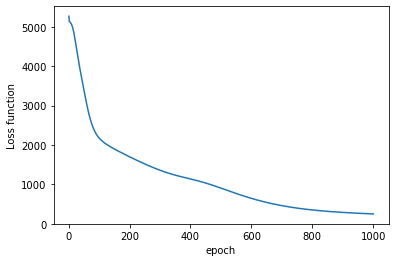

In [13]:
err1 = net.errors[:1000]

x = list(range(1, len(err1)+1))

plt.plot(x, err1)

plt.ylabel('Loss function')
plt.xlabel('epoch')
plt.show()

In [11]:
out = net.predict(x_test)
mse = mse(out, y_test)
print(mse) # 689.2154091460627

713.51824963074


In [ ]:
np.random.seed(20)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=10000, learning_rate=0.0005, batch_size=20, x_val=x_val, y_val=y_val)

In [ ]:
err1 = net.errors
err2 = net.val_errors

In [ ]:
x = list(range(1, len(err1)+1))

plt.plot(x, err1, label='train')
plt.plot(x, err2, label='val')

plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.show()

In [ ]:
out = net.predict(x_test)
mse = mse(out, y_test)
print(mse)

In [ ]:
np.random.seed(20)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=10000, learning_rate=0.0005, batch_size=20,
        early_stopping=3, x_val=x_val, y_val=y_val)

In [ ]:
err1 = net.errors
err2 = net.val_errors

x = list(range(1, len(err1)+1))

plt.plot(x, err1, label='train')
plt.plot(x, err2, label='val')

plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.show()

In [ ]:
np.random.seed(20)
net = Network()
net.add(Layer(1, 50))
net.add(ActivationLayer(tanh, derivative_sigmoid))
net.add(Layer(50, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.0005, batch_size=10, regularisation=['L2', 0.01])

In [ ]:
out = net.predict(x_test)
mse = mse(out, y_test)
print(mse) # 689.2154091460627